# Восстановление золота из руды

<b> Описание исследования </b>

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

<b>Цель исследования</b>

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

<b> Задачи исследования</b>

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<b>Данное исследование разделим на несколько частей:</b>

[1. Подготовка данных](#step_1)

[1.1. Откроем файлы и изучим их](#step_2)

[1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишем выводы.](#step_3)

[1.3. Проанализируем признаки, недоступные в тестовой выборке. Опишем что это за параметры. Опишем к какому типу они относятся.](#step_4)

[1.4. Проведем предобработку данных.](#step_5)

[2. Проанализируем данные](#step_6)

[2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.](#step_7)

[2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.](#step_8)

[2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.](#step_9)

[3. Построим модель](#step_10)

[3.1. Напишем функцию для вычисления итоговой sMAPE.](#step_11)

[3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.](#step_12)

[4. Выводы](#step_13)

[5. Чек-лист готовности проекта](#step_14)

<a id=step_1></a>

## Подготовка данных

<b>Загрузка необходимых библиотек</b>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

<b>Загрузка данных из файлов</b>

In [3]:
try:
    df_train = pd.read_csv ('gold_recovery_train_new.csv')
    df_test = pd.read_csv ('gold_recovery_test_new.csv')
    df_full = pd.read_csv ('gold_recovery_full_new.csv')
except:
    df_train = pd.read_csv ('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv ('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv ('/datasets/gold_recovery_full_new.csv')

<b>Функция просмотра данных в файлах</b>

In [4]:
def first_look(df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print('------------- Типы данных ------------')
    print(df.info())
    print('')
    print('')
    print('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(
                element, ' - ', df[element].isna().sum(), \
                'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' 
            )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
            print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

<a id=step_2></a>
<b>1.1. Откроем файлы и изучим их</b>

<b>Данные из обучающего файла</b>

In [5]:
first_look(df_train)

------------- Первые 5 строк ------------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol              

secondary_cleaner.output.tail_sol  -  1605 пропусков,  11.34 % от числа строк.
secondary_cleaner.state.floatbank2_a_air  -  217 пропусков,  1.53 % от числа строк.
secondary_cleaner.state.floatbank2_a_level  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank2_b_air  -  21 пропусков,  0.15 % от числа строк.
secondary_cleaner.state.floatbank2_b_level  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank3_a_air  -  4 пропусков,  0.03 % от числа строк.
secondary_cleaner.state.floatbank3_a_level  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank3_b_air  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank3_b_level  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank4_a_air  -  6 пропусков,  0.04 % от числа строк.
secondary_cleaner.state.floatbank4_a_level  -  1 пропусков,  0.01 % от числа строк.
secondary_cleaner.state.floatbank4_b_air  -  1 пропусков,  0.01 % от числа строк.
second

<b>Данные из тестового файла</b>

In [6]:
first_look(df_test)

------------- Первые 5 строк ------------


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      

<b>Данные из исходного файла</b>

In [7]:
first_look(df_full)

------------- Первые 5 строк ------------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol              

Дубликатов НЕТ
------------- Категориальные признаки ------------


Из прочитанных данных видно, что в обучающей и полной выборке 86 столбцов, а в тестовой всего 52. Также в тестовой выборке отсутствуют целевые признаки final.output.recovery и rougher.output.recovery.

Во всех файлах присутствуют пропуски в данных, дубликатов нет

# Технологический процесс

Как золото получают из руды? Изучите внимательно стадии процесса.
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Опишем каждую стадию:

<b>1. Флотация</b>

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

<b>2. Очистка</b>

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

# Описание данных

<b>Технологический процесс</b>

•	Rougher feed — исходное сырье

•	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

    o	Xanthate **— ксантогенат (промотер, или активатор флотации);
    
    o	Sulphate — сульфат (на данном производстве сульфид натрия);
    
    o	Depressant — депрессант (силикат натрия).
    
•	Rougher process (англ. «грубый процесс») — флотация

•	Rougher tails — отвальные хвосты

•	Float banks — флотационная установка

•	Cleaner process — очистка

•	Rougher Au — черновой концентрат золота

•	Final Au — финальный концентрат золота

<b>Параметры этапов</b>

•	air amount — объём воздуха

•	fluid levels — уровень жидкости

•	feed size — размер гранул сырья

•	feed rate — скорость подачи

# Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

•	rougher — флотация

•	primary_cleaner — первичная очистка

•	secondary_cleaner — вторичная очистка

•	final — финальные характеристики

Возможные значения для блока [тип_параметра]:

•	input — параметры сырья

•	output — параметры продукта

•	state — параметры, характеризующие текущее состояние этапа

•	calculation — расчётные характеристики

<a id=step_3></a>
<b>1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишем выводы.</b>

# Расчёт эффективности

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле
 
 <b>$$Recovery = \frac {C \;x \;(F - T)}{F \;x \;(C - T)}$$</b>
  
где:

•	C — доля золота в концентрате после флотации/очистки;

•	F — доля золота в сырье/концентрате до флотации/очистки;

•	T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Создадим переменную с нашим расчетным значением эффективности в обучающей выборке

In [8]:
recovery = (df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - \
                    df_train['rougher.output.tail_au'])) / (df_train['rougher.input.feed_au'] * \
                    (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'])) * 100

In [9]:
display(recovery.head(5))
print('MAE между нашими расчётами и значением признака:', mean_absolute_error(df_train['rougher.output.recovery'],
                                                                              recovery))

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

MAE между нашими расчётами и значением признака: 9.73512347450521e-15


Т.к. расчитанное отклонение ничтожно мало, можем принять, что эффективность обогащения расчитана верно.

<a id=step_4></a>
<b>1.3. Проанализируем признаки, недоступные в тестовой выборке. Опишем что это за параметры. Опишем к какому типу они относятся.</b>

In [10]:
columns_not_in_test = df_train.columns.drop(df_test.columns)
columns_not_in_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

После сравнения столбцов данных двух файлов, мы видим, что в тестовых данных не хватает тех признаков, которые замеряются и/или рассчитываются значительно позже. В виду этого подобные признаки также не должны быть использованы при обучении модели. Т.е. перед созданием модели их нужно убрать из обучающей выборки. Исключение составляют два целевых признака - final.output.recovery, rougher.output.recovery, т.к. нам их нужно спрогнозировать в дальнейшем.

Удалим из обучающей выборки те столбцы, которые не будут участвовать в обучении моделей

In [11]:
columns_to_drop = columns_not_in_test.drop(['final.output.recovery', 'rougher.output.recovery'])
train_columns = df_train.columns.drop(columns_to_drop)
df_train = df_train[train_columns]

In [12]:
first_look(df_train)

------------- Первые 5 строк ------------


,date,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,70.541216,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,69.266198,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,68.116445,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,68.347543,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,66.927016,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   final.output.recovery                       14149 non-null  float64
 2   primary_cleaner.input.sulfate               14129 non-null  float64
 3   primary_cleaner.input.depressant            14117 non-null  float64
 4   primary_cleaner.input.feed_size             14149 non-null  float64
 5   primary_cleaner.input.xanthate              14049 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level  

<a id=step_5></a>
<b>1.4. Проведем предобработку данных.</b>

Отсортируем наши выборки по дате

In [12]:
df_train = df_train.sort_values(by='date')
df_test = df_test.sort_values(by='date')
df_full = df_full.sort_values(by='date')

Т.к. по описанию данных из проекта сказано, что "Соседние по времени параметры часто похожи", мы можем для заполнения пропусков брать соседние. Проделаем данную операцию с данными из файла с изначальными полными данными.

In [13]:
df_full = df_full.fillna(method='ffill')

Заполним все пропуски в наших выборках соответствующими значениями из изначального файла сохраняя последовательность неизвестного нам семпла

In [14]:
df_train = df_full[df_full.index.isin(df_train.index)][df_train.columns]
df_test = df_full[df_full.index.isin(df_test.index)][df_test.columns]

Проверим что получилось

In [15]:
first_look(df_train)
first_look(df_test)

------------- Первые 5 строк ------------


,date,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,70.541216,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,69.266198,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,68.116445,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,68.347543,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,66.927016,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   final.output.recovery                       14149 non-null  float64
 2   primary_cleaner.input.sulfate               14149 non-null  float64
 3   primary_cleaner.input.depressant            14149 non-null  float64
 4   primary_cleaner.input.feed_size             14149 non-null  float64
 5   primary_cleaner.input.xanthate              14149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level  

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      

Избавимся от нулевых значений в данных, указывающих на наличия концентрации металла после этапа флотации, в промежуточных этапах и в конечном продукте

In [16]:
df_full = df_full[(df_full ['final.output.concentrate_ag'] != 0) & \
                  (df_full ['final.output.concentrate_pb'] != 0) & \
                  (df_full ['final.output.concentrate_sol'] != 0) & \
                  (df_full ['final.output.concentrate_au'] != 0) & \
                  (df_full ['secondary_cleaner.output.tail_ag'] != 0) & \
                  (df_full ['secondary_cleaner.output.tail_pb'] != 0) & \
                  (df_full ['secondary_cleaner.output.tail_sol'] != 0) & \
                  (df_full ['secondary_cleaner.output.tail_au'] != 0) & \
                  (df_full ['primary_cleaner.output.concentrate_ag'] != 0) & \
                  (df_full ['primary_cleaner.output.concentrate_pb'] != 0) & \
                  (df_full ['primary_cleaner.output.concentrate_sol'] != 0) & \
                  (df_full ['primary_cleaner.output.concentrate_au'] != 0) & \
                  (df_full ['rougher.output.concentrate_ag'] != 0) & \
                  (df_full ['rougher.output.concentrate_pb'] != 0) & \
                  (df_full ['rougher.output.concentrate_sol'] != 0) & \
                  (df_full ['rougher.output.concentrate_au'] != 0) & \
                  (df_full ['rougher.input.feed_ag'] != 0) & \
                  (df_full ['rougher.input.feed_pb'] != 0) & \
                  (df_full ['rougher.input.feed_sol'] != 0) & \
                  (df_full ['rougher.input.feed_au'] != 0)
                  ]

In [17]:
first_look(df_full)

------------- Первые 5 строк ------------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17960 entries, 0 to 19429
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                17960 non-null  object 
 1   final.output.concentrate_ag                         17960 non-null  float64
 2   final.output.concentrate_pb                         17960 non-null  float64
 3   final.output.concentrate_sol                        17960 non-null  float64
 4   final.output.concentrate_au                         17960 non-null  float64
 5   final.output.recovery                               17960 non-null  float64
 6   final.output.tail_ag                                17960 non-null  float64
 7   final.output.tail_pb                                17960 non-null  float64
 8   final.output.tail_sol              

Проверим наши данные на мультиколлениарность. Отбросим данные, коррелиция которых меньше 0,8 и 1. Они меньше всего будут влиять на последующее обучение моделей.

In [18]:
corr_features = (
    df_full[df_test.columns].corr().abs().pipe(
        lambda x: x [(0.8 < x) & (x < 1)]).unstack().dropna().drop_duplicates()
)
display(corr_features)

primary_cleaner.state.floatbank8_a_air      primary_cleaner.state.floatbank8_b_air        0.953676
                                            primary_cleaner.state.floatbank8_c_air        0.914825
primary_cleaner.state.floatbank8_a_level    primary_cleaner.state.floatbank8_b_level      0.884770
                                            primary_cleaner.state.floatbank8_c_level      0.943224
primary_cleaner.state.floatbank8_b_air      primary_cleaner.state.floatbank8_c_air        0.922673
primary_cleaner.state.floatbank8_b_level    primary_cleaner.state.floatbank8_c_level      0.870117
rougher.input.feed_ag                       rougher.input.feed_au                         0.844482
rougher.input.floatbank10_sulfate           rougher.input.floatbank11_sulfate             0.907435
rougher.input.floatbank10_xanthate          rougher.input.floatbank11_xanthate            0.901534
rougher.state.floatbank10_b_air             rougher.state.floatbank10_c_air               0.934855
          

Создадим задел столбцов, которые в последствии удалим из обучающей выборки (оставив по одному из соответствующих коррелирующих групп)

In [19]:
corr_drop_columns = corr_features.index.get_level_values(1).drop_duplicates()
corr_drop_columns

Index(['primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_level', 'rougher.input.feed_au',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_f_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level'],
      dtype='object')

Преобразуем наши файлы

In [20]:
train_columns = df_train.columns.drop(corr_drop_columns)
df_train = df_train[train_columns]
test_columns = df_test.columns.drop(corr_drop_columns)
df_test = df_test[test_columns]

df_train = df_full[df_full.index.isin(df_train.index)][train_columns]
df_test = df_full[df_full.index.isin(df_test.index)][test_columns]

Еще раз посмотрим на них после всех манипуляций

In [21]:
first_look(df_train)
first_look(df_test)

------------- Первые 5 строк ------------


,date,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,...,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,70.541216,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1554.367432,-493.428131,...,-495.262817,21.940409,-499.340973,14.016835,-502.488007,-504.715942,9.925633,-498.310211,14.151341,-605.841980
1,2016-01-15 01:00:00,69.266198,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1574.479259,-498.931665,...,-500.085473,22.085714,-499.446897,13.992281,-505.503262,-501.331529,10.039245,-500.169983,13.998353,-599.787184
2,2016-01-15 02:00:00,68.116445,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1599.541515,-499.827444,...,-499.442343,23.957717,-499.901982,14.015015,-502.520901,-501.133383,10.070913,-500.129135,14.028663,-601.427363
3,2016-01-15 03:00:00,68.347543,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.449520,-500.052575,...,-500.008812,23.954443,-499.944710,14.036510,-500.857308,-501.193686,9.970366,-499.201640,14.005551,-599.996129
4,2016-01-15 04:00:00,66.927016,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1602.649541,-500.593010,...,-500.083811,23.958945,-499.990309,14.027298,-499.838632,-501.053894,9.925709,-501.686727,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13052 entries, 0 to 14148
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13052 non-null  object 
 1   final.output.recovery                       13052 non-null  float64
 2   primary_cleaner.input.sulfate               13052 non-null  float64
 3   primary_cleaner.input.depressant            13052 non-null  float64
 4   primary_cleaner.input.feed_size             13052 non-null  float64
 5   primary_cleaner.input.xanthate              13052 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13052 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13052 non-null  float64
 8   primary_cleaner.state.floatbank8_d_air      13052 non-null  float64
 9   primary_cleaner.state.floatbank8_d_level  

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,...,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1554.367432,-493.428131,6.100378,...,-495.262817,21.940409,-499.340973,14.016835,-502.488007,-504.715942,9.925633,-498.310211,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1574.479259,-498.931665,6.161113,...,-500.085473,22.085714,-499.446897,13.992281,-505.503262,-501.331529,10.039245,-500.169983,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1599.541515,-499.827444,6.116455,...,-499.442343,23.957717,-499.901982,14.015015,-502.520901,-501.133383,10.070913,-500.129135,14.028663,-601.427363
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.449520,-500.052575,6.043309,...,-500.008812,23.954443,-499.944710,14.036510,-500.857308,-501.193686,9.970366,-499.201640,14.005551,-599.996129
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1602.649541,-500.593010,6.060915,...,-500.083811,23.958945,-499.990309,14.027298,-499.838632,-501.053894,9.925709,-501.686727,13.996647,-601.496691




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5085 entries, 0 to 5289
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5085 non-null   object 
 1   primary_cleaner.input.sulfate               5085 non-null   float64
 2   primary_cleaner.input.depressant            5085 non-null   float64
 3   primary_cleaner.input.feed_size             5085 non-null   float64
 4   primary_cleaner.input.xanthate              5085 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5085 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5085 non-null   float64
 7   primary_cleaner.state.floatbank8_d_air      5085 non-null   float64
 8   primary_cleaner.state.floatbank8_d_level    5085 non-null   float64
 9   rougher.input.feed_ag                       

На данном этапе мы проверили, что эффективность обогащения рассчитана правильно.

Проанализировали признаки, недоступные в тестовой выборке.

Описали что это за параметры, описали к какому типу они относятся

Провели предобработку данных, а именно:

- заполнили пропуски в данных данными из соседних

- избавились от нулевых значений в данных

- проверили наши выборки на коллениарность и подготовили их для моделей обучения

<a id=step_6></a>
## Проанализируем данные

<a id=step_7></a>
<b>2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.</b>

Создадим функцию прорисовки графиков распредления металла по этапам очистки

In [22]:
def display_graf(metal: str, x_lim: int, y_lim: int)-> None:
    
    plt.figure(figsize = [12, 9])
    
    plt.hist(
        df_full.loc[:, (
            df_full.columns.str.contains(metal) & df_full.columns.str.contains('final.output.concentrate')
        )], bins=100, label='финальный продукт', alpha=.5)
    plt.hist(
        df_full.loc[:, (
            df_full.columns.str.contains(metal) & df_full.columns.str.contains('secondary_cleaner.output.tail')
        )], bins=100, label='отвальные хвосты после вторичной отчистки', alpha=.5)
    plt.hist(
        df_full.loc[:, (
            df_full.columns.str.contains(metal) \
            & df_full.columns.str.contains('primary_cleaner.output.concentrate')
        )], bins=100, label='продукт после первичной очистки', alpha=.5)
    plt.hist(
        df_full.loc[:, (
            df_full.columns.str.contains(metal) & df_full.columns.str.contains('rougher.output.concentrate')
        )], bins=100, label='продукт после флотации', alpha=.5)
    plt.hist(
        df_full.loc[:, (
            df_full.columns.str.contains(metal) & df_full.columns.str.contains('rougher.input.feed')
        )], bins=100, label='исходное сырье', alpha=.5)
    
    plt.xlim([0, x_lim])
    plt.ylim([0, y_lim])

    plt.xlabel(f'Концентрация {metal} на выходе')
    plt.ylabel('Частота')

    plt.legend(loc='upper left', fontsize='x-large')

    plt.title(f'Гистограмма распределения концентрации {metal}')
    plt.show()

Концентрация золота на различных этапах очистки

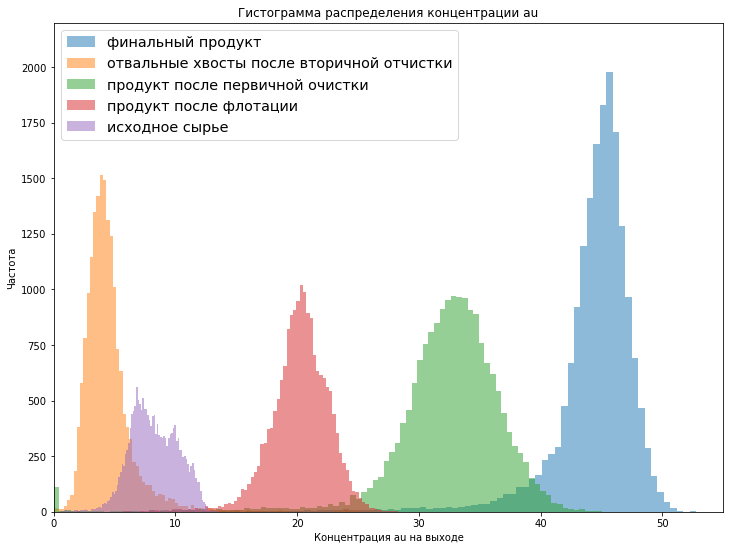

In [23]:
display_graf('au', 55, 2200)

Концентрация серебра на различных этапах очистки

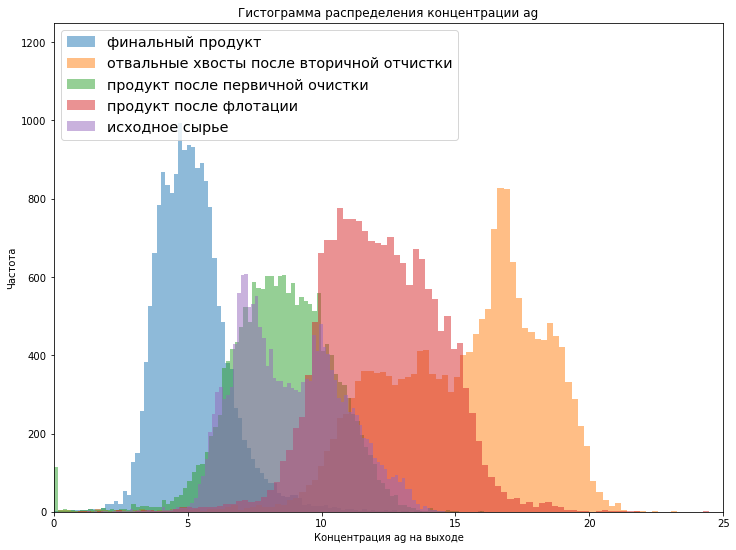

In [24]:
display_graf('ag', 25, 1250)

Концентрация свинца на различных этапах очистки

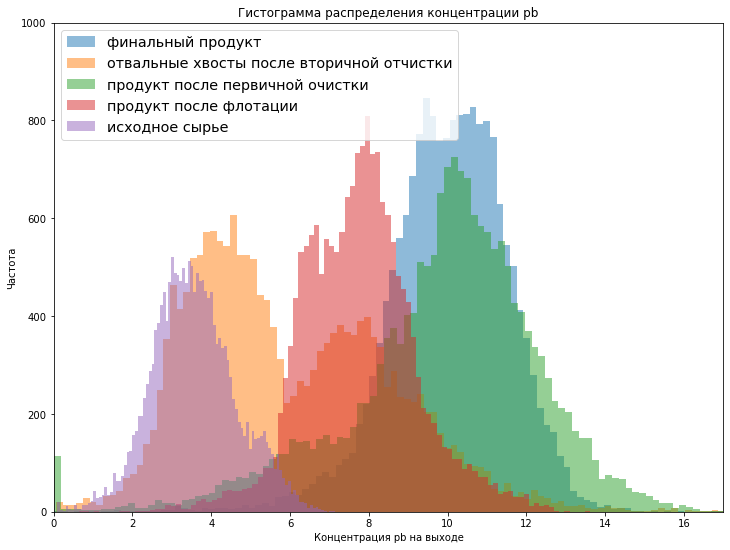

In [25]:
display_graf('pb', 17, 1000)

Из произведенного анализа мы видим, что концентрация золота от этапа к этапу увеличивается, в отвальных концах также наблюдаем небольшую концентрацию, но она мала.

Концентрация серебра увеличивается после флотации, уменьшается после этапа первичной очистки, большая в отвальных частях и незначительная в финальном концентрате.

Концентрация свинца от этапа к этапу равномерно увеличивается, небольшая часть имеется в отвальных частях.

<a id=step_8></a>
<b>2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.</b>

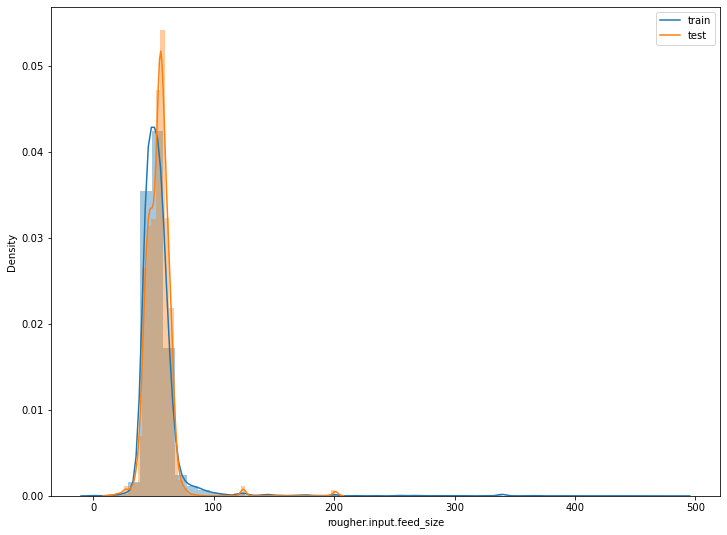

In [26]:
plt.figure(figsize=[12, 9])
sns.distplot(df_train['rougher.input.feed_size'], norm_hist=True)
sns.distplot(df_test['rougher.input.feed_size'], norm_hist=True)
plt.legend(['train', 'test'])
plt.show()

На графике распределения размеров гранул сырья на обучающей и тестовой выборках видим, что распределение не отличается, значит оценку моделей можно проводить на тестовой выборке

<a id=step_9></a>
<b>2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.</b>

Подсчитаем суммарную концентрацию всех веществ на разных стадиях в отдельных столбцах

In [27]:
df_full['sum_concentrate_input_feed'] = df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_ag'] + \
                                            df_full['rougher.input.feed_pb']
df_full['sum_rougher.output.concentrate'] = df_full['rougher.output.concentrate_au'] + \
                                            df_full['rougher.output.concentrate_ag'] + \
                                            df_full['rougher.output.concentrate_pb']
df_full['sum_final.output.concentrate'] = df_full['final.output.concentrate_au'] + \
                                            df_full['final.output.concentrate_ag'] + \
                                            df_full['final.output.concentrate_pb']

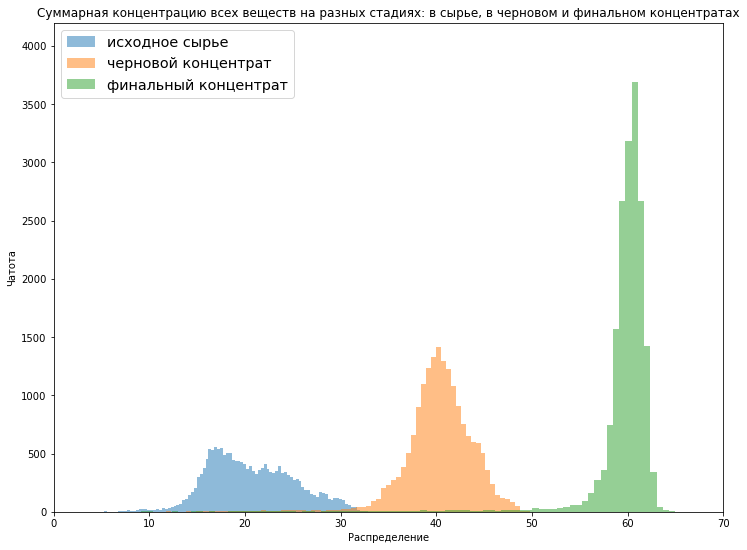

In [28]:
plt.figure(figsize=[12, 9])
    
plt.hist(df_full['sum_concentrate_input_feed'], bins=100, label='исходное сырье', alpha=.5)
plt.hist(df_full['sum_rougher.output.concentrate'], bins=100, label='черновой концентрат', alpha=.5)
plt.hist(df_full['sum_final.output.concentrate'], bins=100, label='финальный концентрат', alpha=.5)

plt.xlim([0, 70])
plt.ylim([0, 4200])

plt.xlabel('Распределение')
plt.ylabel('Чатота')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах')
plt.show()

Из графика наблюдаем увеличение суммарной концентрации всех веществ после каждой стадии очистки.

<a id=step_10></a>
## Построим модель

# Метрика качества

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:
 
 <b>$$sMAPE = \frac {1}{N}\sum^N_{i=1}\frac {\vert {y_i - \overline {y}_i\vert}}{(\vert y_i \vert + \vert \overline {y}_i \vert)/2}x100%$$</b>
 

Обозначения:

<b>$$y_i$$</b>
 
•	Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

<b>$$\overline {y}_i$$</b>
 
•	Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

<b>$$N$$</b>
 
•	Количество объектов в выборке.

<b>$$\sum^N_{i=1}$$</b>
 
•	Суммирование по всем объектам выборки (i меняется от 1 до N).
Нужно спрогнозировать сразу две величины:
1.	эффективность обогащения чернового концентрата rougher.output.recovery;
2.	эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:

<b>Итогоаое sMAPE = 25% x sMAPE (rougher) + 75% sMAPE (final)</b>

<a id=step_11></a>
<b>3.1. Напишем функцию для вычисления итоговой sMAPE.</b>

Функция sMAPE

In [29]:
def s_mape(target: pd.Series, prediction: pd.Series)-> float:
    return (
        1 / len(target)
    ) * (
        sum(
            2 * abs(target - prediction) / (
                abs(target) + abs(prediction)
            ) * 100)
    )

Функция final_sMape

In [30]:
def final_smape(rougher: float, final: float)-> float:
    return 0.25 * rougher + 0.75 * final

<a id=step_12></a>
<b>3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.</b>

Сформируем признаки и целевые признаки для обучения моделей

In [31]:
features = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = df_test.drop(['date'], axis=1)
target_rougher = df_train['rougher.output.recovery']
target_final = df_train['final.output.recovery']

Маштабируем признаки для модели линейной регрессии

In [32]:
features_lr = features.copy()
numeric = features_lr.columns
scaler = StandardScaler()

scaler.fit(features_lr[numeric])
features_lr[numeric] = scaler.transform(features_lr[numeric])

Обучим модель линейной регриссии

In [33]:
model = LinearRegression()

smape_scorer = make_scorer(s_mape, greater_is_better=False)
crossv_rougher = cross_val_score(model, features_lr, target_rougher, scoring=smape_scorer, cv=5)
crossv_final = cross_val_score(model, features_lr, target_final, scoring=smape_scorer, cv=5)
                                 
print('Final_sMAPE модели линейной регрессии:', final_smape(crossv_rougher.mean(), crossv_final.mean()))

Final_sMAPE модели линейной регрессии: -9.212630506723317


Обучим модель дерева решений

In [34]:
best_depth = 0
best_smape = -100
for depth in range(1, 8):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    smape_scorer = make_scorer(s_mape, greater_is_better=False)
    crossv_rougher = cross_val_score(model, features, target_rougher, scoring=smape_scorer, cv=5)
    crossv_final = cross_val_score(model, features, target_final, scoring=smape_scorer, cv=5)
    smape = final_smape(crossv_rougher.mean(), crossv_final.mean())
    if abs (smape) < abs (best_smape):
        best_depth = depth
        best_smape = smape
print("Final_sMAPE лучшей модели:", best_smape, 'при лучшей глубине:', best_depth)

Final_sMAPE лучшей модели: -7.91774914441341 при лучшей глубине: 2


Обучим модель случайного дерева

In [35]:
best_smape = -100
best_est = 0
best_depth = 0
for est in range(3, 6, 1):
    for depth in range(1, 4, 1):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        smape_scorer = make_scorer(s_mape, greater_is_better=False)
        crossv_rougher = cross_val_score(model, features_lr, target_rougher, scoring=smape_scorer, cv=5)
        crossv_final = cross_val_score(model, features_lr, target_final, scoring=smape_scorer, cv=5)
        smape = final_smape(crossv_rougher.mean(), crossv_final.mean())
        if abs (smape) < abs (best_smape):
            best_smape = smape
            best_est = est
            best_depth = depth
print ("Final_sMAPE лучшей модели:", best_smape, "Количество деревьев:", best_est, \
       "Максимальная глубина:", best_depth)

Final_sMAPE лучшей модели: -7.848373609314212 Количество деревьев: 4 Максимальная глубина: 2


Модель линейное регрессии показала результат на обучающей выборке -9.212630506723315.

Модель дерева решений -7.91774914441341 при лучшей глубине: 2.

Модель случайного дерева -7.848373609314212 при количествt деревьев: 4 и максимальноq глубине: 2.

Лучше всего себя показала модель случайного дерева.

Проверим ее на тестовой выборке

In [36]:
target_test_rougher = df_full[df_full.index.isin(df_test.index)]['rougher.output.recovery']
target_test_final = df_full[df_full.index.isin(df_test.index)]['final.output.recovery']

Проверим нашу полученную модель на тестовой выборке

In [37]:
model = RandomForestRegressor(random_state=12345, n_estimators=4, max_depth=2)

smape_scorer = make_scorer(s_mape, greater_is_better=False)
crossv_rougher = cross_val_score(model, features_test, target_test_rougher, scoring=smape_scorer, cv=5)
crossv_final = cross_val_score(model, features_test, target_test_final, scoring=smape_scorer, cv=5)

smape = final_smape(crossv_rougher.mean(), crossv_final.mean())

print('Final_sMAPE модели случайного леса на тестовой выборке:', smape)

Final_sMAPE модели случайного леса на тестовой выборке: -8.720405606119257


Проверим модель на адекватность в сравнении с простейшей моделью

In [38]:
model = DummyRegressor(strategy='mean')

model.fit(features_test, target_test_rougher)
predictions_rougher = model.predict(features_test)

model.fit(features_test, target_test_final)
predictions_final = model.predict(features_test)

crossv_rougher = cross_val_score(model, features_test, target_test_rougher, scoring=smape_scorer, cv=5)
crossv_final = cross_val_score(model, features_test, target_test_final, scoring=smape_scorer, cv=5)

smape = final_smape(crossv_rougher.mean(), crossv_final.mean())

print('Итоговое sMAPE', smape)

Итоговое sMAPE -9.483582796527294


По полученным данным мы убеждаемся, что наша модель работает лучше, что показывает значение метрики

В нашем проекте мы:
- считали данные из файлов
- проверили формулу вычисления эффективности обогащения
- проанализировали признаки, недоступные в тестовой выборке
- провели предобработку данных
- исследовали изменение концентрации элементов на каждом этапе
- проанализировали распределения размеров гранул на обучающей и тестовой выборках
- исследовали суммарные концентрации
- написали функцию для вычисления итогового *sMAPE*
- бучели и проверили несколько моделей
- выбрали лучшау модель, её качество проверили на тестовой выборке

По результатам наших исследований можно рекомендовать нашу модель для последующей работы

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [X]  Исследованы суммарные концентрации
- [X]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке